In [2]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
import csv
from decimal import *
import pickle
from scipy.interpolate import interp1d
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# from operator import mul    # or mul=lambda x,y:x*y
# from fractions import Fraction

import operator as op
def nCr(n, r):
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom

# def nCr(n,r): 
#   return int( reduce(mul, (Fraction(n-i, i+1) for i in range(r)), 1) )

# def nCr(n,r):
#     f = math.factorial
#     return f(n) / f(r) / f(n-r)

# Use python round
# def round(x, n):
#     return int(np.rint(a * 10**n)) / 10.**n

In [4]:
# For scipy Linear Interpolation
def hs_rs_table(rate, blocklength):
    k = (1-rate)*blocklength
    msg = rate*blocklength
    op_SNR = arange(0, 5, 0.01)
    pbitdrop = array([0.5*math.erfc(sqrt(10**opsnr/2)) for opsnr in op_SNR])
    hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
    hcflst = 1 - (1-hcerr)**2
    reeddrop = [sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]) \
                for hcf in hcflst]
#     func = interp1d(op_SNR, reeddrop, kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    return [op_SNR, reeddrop]

In [5]:
def save_table(table, filename):
    f = open(filename, 'w')
    pickle.dump(table, f)
    f.close()
    
def load_table(filename):
    f = open(filename, 'r')
    table = pickle.load(f)
    f.close()
    return table

In [124]:
# Linear interpolation function
def p_single(codetable, op_SNR, endpoint, dfade, tabledSNR):
    fadexp = sp.stats.expon()
    psingle = []
    fade = arange(0, endpoint[0], dfade[0])
    snrlookup = codetable(op_SNR+log10(fade))
    fadepr = fadexp.pdf(fade)
    psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpoint)):
        fade = arange(endpoint[idx-1], endpoint[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
    return sum(psingle)

In [125]:
def p_combo(codetable, a, op_SNR, endpoint, dfade, tabledSNR):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    pcombo = []
    fade = arange(0, endpoint[0], dfade[0])
    snrlookup = codetable(op_SNR+log10(fade))
    fadepr = fadexp.pdf(fade)
    pcombo.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpoint)):
        fade = arange(endpoint[idx-1], endpoint[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        pcombo.append(dfade[idx]*np.dot(snrlookup, fadepr))
#         pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[idx] for f in fade]))
    return sum(pcombo)

In [126]:
# N = num_nodes
def p_protocol(codetable, N, op_SNR, endpoint, dfade, tabledSNR):
    psingle = p_single(codetable, op_SNR, endpoint, dfade, tabledSNR)
#     print('psingle', psingle, 'pcombo, ')
    return sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * 
                (1-(1-p_combo(codetable, a, op_SNR, endpoint, dfade, tabledSNR))**(N-a)) for a in range(N)])

In [9]:
def shannon_combo(N, a, rate1, p1, SNR):
    rate2 = (N-a)/N*rate1 + 2*N/10000
    p2 = 1 - exp(-(2**rate2 -1)/(10**(SNR/10)))
    return p2**a * min(p2/p1, 1)

[  9.99999972e-10   8.99999964e-10   7.99999955e-10   6.99999947e-10
   6.00000050e-10   5.00000041e-10   4.00000033e-10   3.00000025e-10
   2.00000017e-10   1.00000008e-10]


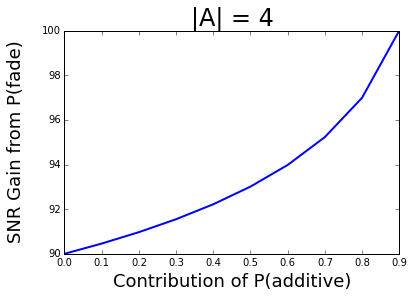

In [49]:
ratio = arange(0, 1, 0.1)

target = 10**(-9)
padd = ratio*target
a = 1
pfade = (target - padd)**(1/a)
print(-log(1 - pfade))
snr_gain = -10*log10(-log(1 - pfade))
plot(ratio, snr_gain, lw=2.0)
ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = 4', fontsize=24)

In [33]:
%%time
num_nodes = 4

numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

param = 10**(-9)
msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)

actual = []
rate = num_nodes*msgsize/blocklength
k = (1-rate)*rsblock

pdbit = arange(0,0.15,0.001) # bit error prob
hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
hammfail = 1 - (1-hcerr)**numwords

for r in ratio:
    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > r*param:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    actual.append(minSNR)

plot(ratio, 10*log10(actual), lw=2.0)
ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = 4', fontsize=24)

[3.9099859007707414, 1.8481389561801478, 1.8310802925367025, 1.8310802925367025, 1.8310802925367025, 1.8310802925367025, 1.8310802925367025, 1.8310802925367025, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.8142436625078482, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537, 1.7976240603656537,

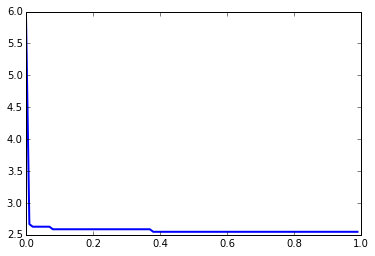

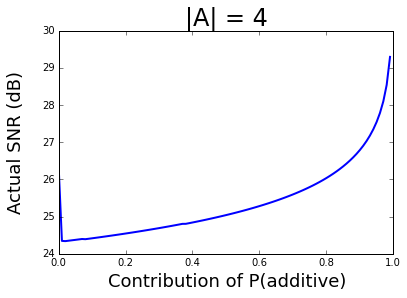

In [41]:
plot(ratio, snr_gain+array(actual), lw=2.0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)
savefig('a=4.pdf', bbox='tight')

CPU times: user 11.1 s, sys: 191 ms, total: 11.3 s
Wall time: 11.4 s


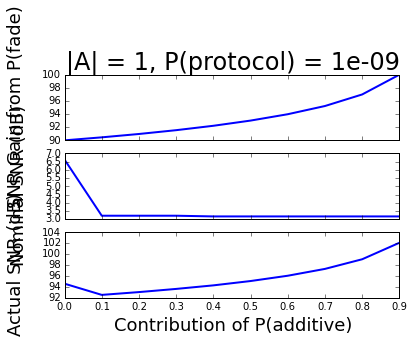

In [12]:
%%time
ratio = arange(0, 1, 0.1)
num_nodes = 1
msgsize = 160
blocklength = 10000
rate = 15*msgsize/blocklength

target = 10**(-9)
padd = ratio*target
pfade = (target - padd)**(1/num_nodes)
snr_gain = -10*log10(-log(1 - pfade))
f1, orig = subplots(3, sharex=True)
orig[0].plot(ratio, snr_gain, lw=2.0)
orig[0].set_ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
# orig[0].set_xlabel('Contribution of P(additive)', fontsize=18)
orig[0].set_title('|A| = {0}, P(protocol) = {1}'.format(num_nodes, target), fontsize=24)

numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

rsblock = int(blocklength/bpw)

actual = []
ptracker = []
# rate = num_nodes*msgsize/blocklength
k = (1-rate)*rsblock

pdbit = arange(0,0.15,0.001) # bit error prob
hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
hammfail = 1 - (1-hcerr)**numwords

for r in ratio:
    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > r*target:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    actual.append(minSNR)
    ptracker.append(pbcrit)

# figure()
orig[1].plot(ratio, 10*log10(actual), lw=2.0)
orig[1].set_ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
# orig[1].set_xlabel('Contribution of P(additive)', fontsize=18)
# title('|A| = {0}'.format(num_nodes), fontsize=24)

# figure()
orig[2].plot(ratio, snr_gain+array(actual), lw=2.0)
orig[2].set_ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
orig[2].set_xlabel('Contribution of P(additive)', fontsize=18)
# savefig('a={0}.pdf'.format(num_nodes), bbox='tight')

In [14]:
# Almost instantaneous--50 ms
def snrgain(dratio, target, strong_nodes, users):
    ratio = arange(0, 1, dratio)
    msgsize = 160
    blocklength = 10000
    rate = users*msgsize/blocklength

    padd = ratio*target
    pfade = (target - padd)**(1/strong_nodes)
    snr_gain = -10*log10(-log(1 - pfade))
    return snr_gain


In [ ]:
def reverse_lookup(n, padd):
    filename = 'lookup_0-01/n' + str(n) + '.in'
    codetable = load_table(filename)
    revfunc = interp1d(codetable[1], codetable[0], kind='linear', bounds_error=False, fill_value=(float("inf"), -float("inf")))
    

In [29]:
def nominalsnr_ratio(dratio, target, users):
    ratio = arange(0, 1, dratio)
    numwords = 3 # number of hamming code blocks stuck together
    bpw = 21 # bits per word
    blocklength = 10000
    rsblock = int(blocklength/bpw)
    rate = users*160/blocklength

    nominal = []
    ptracker = []

    k = (1-rate)*rsblock

    pdbit = arange(0,0.15,0.001) # bit error prob
    hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
    hammfail = 1 - (1-hcerr)**numwords

    for r in ratio:
        for hcf in hammfail:
            reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
            if reed > r*target:
                break
        idx = np.where(hammfail==hcf)[0][0]
        hccrit = hammfail[idx-1]
        pbcrit = pdbit[idx-1]
#         minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
#         nominal.append(minSNR)
        ptracker.append(pbcrit)
        
    ptracker = array(ptracker)
    nominal = (sqrt(2)*sp.special.erfinv(1-2*ptracker))**2
    return 10*log10(array(nominal)), ptracker

In [48]:
def nominalsnr_ratio(dratio, target, users):
    ratio = arange(0, 1, dratio)
#     numwords = 3 # number of hamming code blocks stuck together
#     bpw = 21 # bits per word
#     blocklength = 10000
#     rsblock = int(blocklength/bpw)
    rate = users*160/10000
    padd = ratio*target # + 10**(-20)
    filename = 'lookup_0-01/n' + str(users) + '.in'
    codetable = load_table(filename)
    revfunc = interp1d(codetable[1], codetable[0], kind='linear') #, bounds_error=False, fill_value=(float("inf"), -float("inf")))
    snr_needed_db = revfunc(padd)
    return snr_needed_db

CPU times: user 141 ms, sys: 1.72 ms, total: 142 ms
Wall time: 143 ms


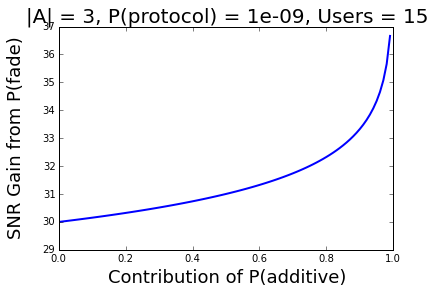

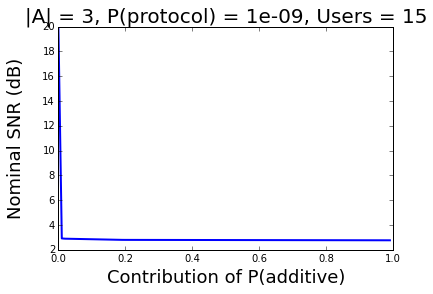

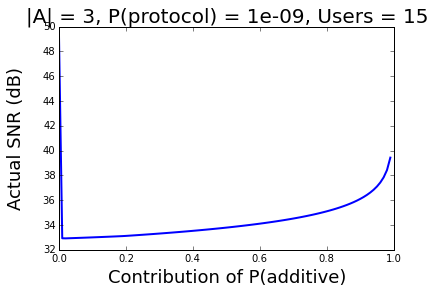

In [49]:
%%time
dratio, target, strong_nodes, users = 0.01, 10**(-9), 3, 15
ratio = arange(0, 1, dratio)
gain = snrgain(dratio, target, strong_nodes, users)
nominaldB = 10*nominalsnr_ratio(dratio, target, users)
# nominaldB, pcrit = nominalsnr_ratio(dratio, target, users)

figure()
plot(ratio, gain, lw=2.0)
ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}, Users = {2}'.format(strong_nodes, target, users), fontsize=20)

figure()
plot(ratio, nominaldB, lw=2.0)
ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}, Users = {2}'.format(strong_nodes, target, users), fontsize=20)

figure()
plot(ratio, gain+nominaldB, lw=2.0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}, Users = {2}'.format(strong_nodes, target, users), fontsize=20)

In [ ]:
dratio, target, strong_nodes, users = 0.01, 10**(-9), 3, 15
ratio = arange(0, 1, dratio)
gain = snrgain(dratio, target, strong_nodes, users)
nominaldB, pcrit = nominalsnr_ratio(dratio, target, users)

CPU times: user 18.4 s, sys: 337 ms, total: 18.8 s
Wall time: 36.6 s
Parser   : 265 ms


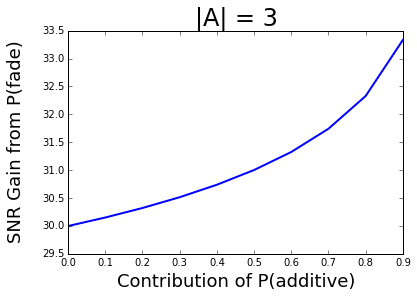

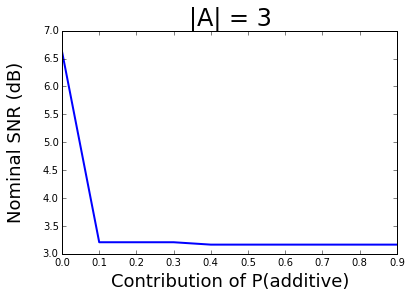

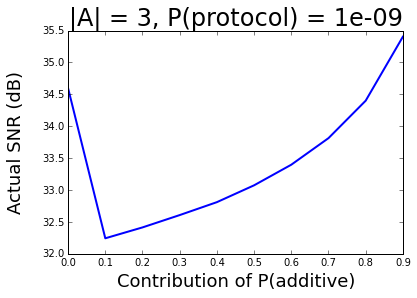

In [54]:
%%time
ratio = arange(0, 1, 0.1)
num_nodes = 3
msgsize = 160
blocklength = 10000
users = 15
rate = users*msgsize/blocklength

target = 10**(-9)
padd = ratio*target
pfade = (target - padd)**(1/num_nodes)
snr_gain = -10*log10(-log(1 - pfade))
figure()
plot(ratio, snr_gain, lw=2.0)
ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

rsblock = int(blocklength/bpw)

actual = []
ptracker = []

k = (1-rate)*rsblock

pdbit = arange(0,0.15,0.001) # bit error prob
hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
hammfail = 1 - (1-hcerr)**numwords

for r in ratio:
    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > r*target:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    actual.append(minSNR)
    ptracker.append(pbcrit)

figure()
plot(ratio, 10*log10(actual), lw=2.0)
ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

figure()
plot(ratio, snr_gain+array(actual), lw=2.0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}'.format(num_nodes, target), fontsize=24)
# savefig('a={0}.pdf'.format(num_nodes), bbox='tight')

CPU times: user 18.6 s, sys: 279 ms, total: 18.8 s
Wall time: 34.5 s


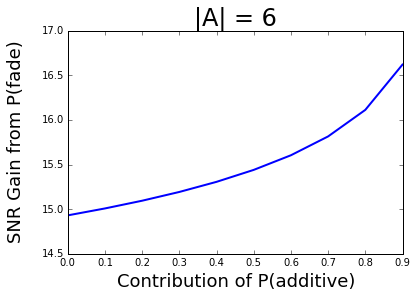

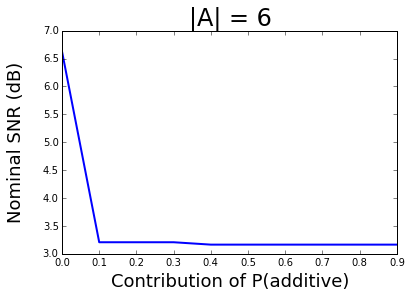

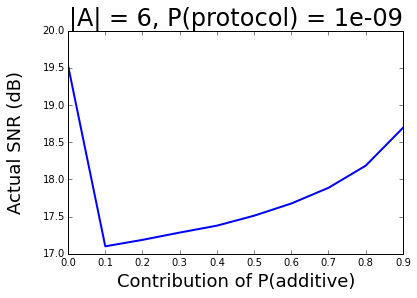

In [55]:
%%time
ratio = arange(0, 1, 0.1)
num_nodes = 6

target = 10**(-9)
padd = ratio*target
pfade = (target - padd)**(1/num_nodes)
snr_gain = -10*log10(-log(1 - pfade))
figure()
plot(ratio, snr_gain, lw=2.0)
ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)

actual = []
ptracker = []
# rate = num_nodes*msgsize/blocklength
rate = 15*160/10000
k = (1-rate)*rsblock

pdbit = arange(0,0.15,0.001) # bit error prob
hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
hammfail = 1 - (1-hcerr)**numwords

for r in ratio:
    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > r*target:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    actual.append(minSNR)
    ptracker.append(pbcrit)

figure()
plot(ratio, 10*log10(actual), lw=2.0)
ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

figure()
plot(ratio, snr_gain+array(actual), lw=2.0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}'.format(num_nodes, target), fontsize=24)
savefig('a={0}.pdf'.format(num_nodes), bbox='tight')

CPU times: user 16.3 s, sys: 197 ms, total: 16.5 s
Wall time: 21.4 s


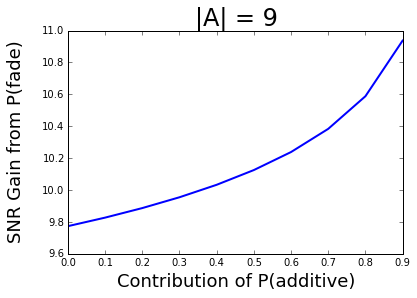

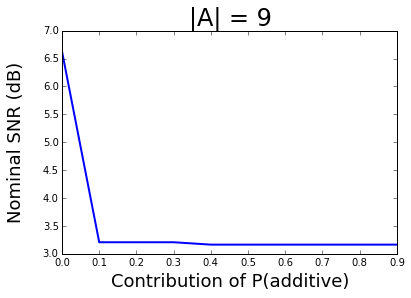

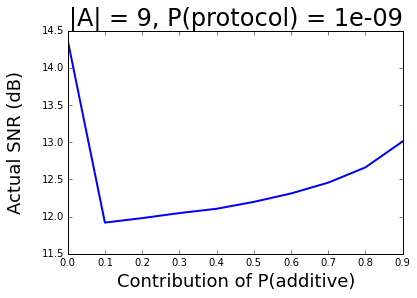

In [56]:
%%time
ratio = arange(0, 1, 0.1)
num_nodes = 9

target = 10**(-9)
padd = ratio*target
pfade = (target - padd)**(1/num_nodes)
snr_gain = -10*log10(-log(1 - pfade))
figure()
plot(ratio, snr_gain, lw=2.0)
ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)

actual = []
ptracker = []
# rate = num_nodes*msgsize/blocklength
rate = 15*160/10000
k = (1-rate)*rsblock

pdbit = arange(0,0.15,0.001) # bit error prob
hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
hammfail = 1 - (1-hcerr)**numwords

for r in ratio:
    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > r*target:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    actual.append(minSNR)
    ptracker.append(pbcrit)

figure()
plot(ratio, 10*log10(actual), lw=2.0)
ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

figure()
plot(ratio, snr_gain+array(actual), lw=2.0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}'.format(num_nodes, target), fontsize=24)
savefig('a={0}.pdf'.format(num_nodes), bbox='tight')

CPU times: user 14.4 s, sys: 350 ms, total: 14.8 s
Wall time: 18.4 s


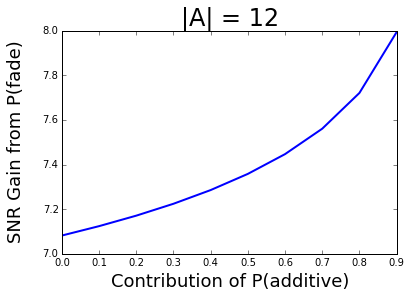

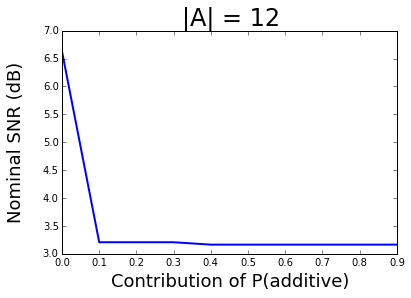

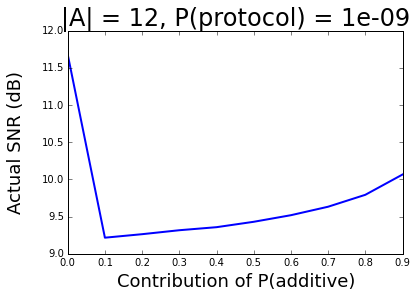

In [59]:
%%time
ratio = arange(0, 1, 0.1)
num_nodes = 12

target = 10**(-9)
padd = ratio*target
pfade = (target - padd)**(1/num_nodes)
snr_gain = -10*log10(-log(1 - pfade))
figure()
plot(ratio, snr_gain, lw=2.0)
ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)

actual = []
ptracker = []
# rate = num_nodes*msgsize/blocklength
rate = 15*160/10000
k = (1-rate)*rsblock

pdbit = arange(0,0.15,0.001) # bit error prob
hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
hammfail = 1 - (1-hcerr)**numwords

for r in ratio:
    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > r*target:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    actual.append(minSNR)
    ptracker.append(pbcrit)

figure()
plot(ratio, 10*log10(actual), lw=2.0)
ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

figure()
plot(ratio, snr_gain+array(actual), lw=2.0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}'.format(num_nodes, target), fontsize=24)
savefig('a={0}.pdf'.format(num_nodes), bbox='tight')

CPU times: user 15.9 s, sys: 260 ms, total: 16.2 s
Wall time: 21.2 s


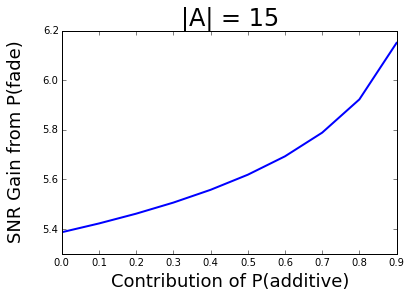

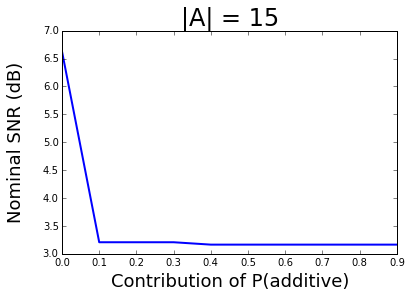

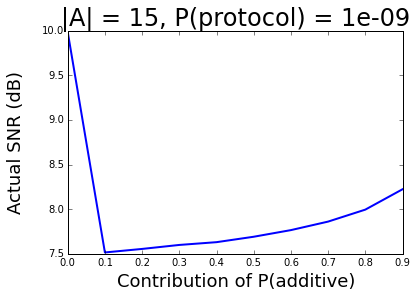

In [60]:
%%time
ratio = arange(0, 1, 0.1)
num_nodes = 15

target = 10**(-9)
padd = ratio*target
pfade = (target - padd)**(1/num_nodes)
snr_gain = -10*log10(-log(1 - pfade))
figure()
plot(ratio, snr_gain, lw=2.0)
ylabel('SNR Gain from P(fade)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)

actual = []
ptracker = []
# rate = num_nodes*msgsize/blocklength
rate = 15*160/10000
k = (1-rate)*rsblock

pdbit = arange(0,0.15,0.001) # bit error prob
hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
hammfail = 1 - (1-hcerr)**numwords

for r in ratio:
    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > r*target:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    actual.append(minSNR)
    ptracker.append(pbcrit)

figure()
plot(ratio, 10*log10(actual), lw=2.0)
ylabel('Nominal SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}'.format(num_nodes), fontsize=24)

figure()
plot(ratio, snr_gain+array(actual), lw=2.0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('|A| = {0}, P(protocol) = {1}'.format(num_nodes, target), fontsize=24)
savefig('a={0}.pdf'.format(num_nodes), bbox='tight')

In [38]:
10*log10((sqrt(2)*sp.special.erfinv(1-2*0.01))**2)

7.3334931629629256

In [39]:
10*log10(5)

6.9897000433601884

1.98
[ 0.28514203  0.28458995  0.28403786  0.28348577  0.28293368  0.28238159
  0.2818295   0.28127741  0.28072532  0.28017324  0.27997125  0.27992936
  0.27988747  0.27984557  0.27980368  0.27976179  0.27971989  0.279678
  0.27963611  0.27959422  0.27955232  0.27951043  0.27946854  0.27942664
  0.27938475  0.27934286  0.27930096  0.27925907  0.27921718  0.27917529
  0.27913339  0.2790915   0.27904961  0.27900771  0.27896582  0.27892393
  0.27888203  0.27884014  0.27879825  0.27875636  0.27871446  0.27867257
  0.27863068  0.27858878  0.27854689  0.278505    0.27846311  0.27842121
  0.27837932  0.27833743  0.27829553  0.27825364  0.27821175  0.27816985
  0.27812796  0.27808607  0.27804418  0.27800228  0.27796039  0.2779185
  0.2778766   0.27783471  0.27779282  0.27775092  0.27770903  0.27766714
  0.27762525  0.27758335  0.27754146  0.27749957  0.27745767  0.27741578
  0.27737389  0.27733199  0.2772901   0.27724821  0.27720632  0.27716442
  0.27712253  0.27708064  0.27703874  0.27699685 

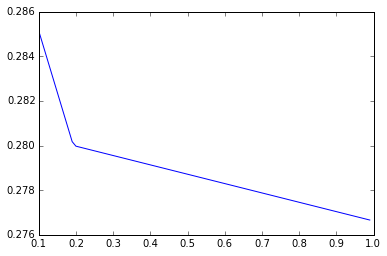

In [45]:
users = 15
filename = 'lookup_0-01/n' + str(users) + '.in'
codetable = load_table(filename)
revfunc = interp1d(codetable[1], codetable[0], kind='linear')
y = revfunc(0.0)
padd = arange(0.1, 1, 0.01) * 10**(-9)
z = revfunc(padd)
print(y)
print(z)
plot(arange(0.1, 1, 0.01), z)

CPU times: user 280 ms, sys: 11.5 ms, total: 291 ms
Wall time: 320 ms


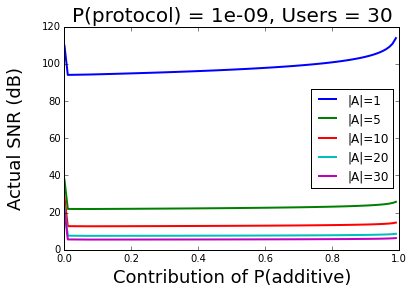

In [55]:
%%time
dratio, target, users = 0.01, 10**(-9), 30
ratio = arange(0, 1, dratio)

for strong_nodes in [1, 5, 10, 20, 30]:
    gain = snrgain(dratio, target, strong_nodes, users)
    nominaldB = 10*nominalsnr_ratio(dratio, target, users)
# nominaldB, pcrit = nominalsnr_ratio(dratio, target, users)
    plot(ratio, gain+nominaldB, lw=2.0, label='|A|={0}'.format(strong_nodes))

legend(loc=0)
ylabel('Actual SNR (dB)', fontsize=18, labelpad=18)
xlabel('Contribution of P(additive)', fontsize=18)
title('P(protocol) = {0}, Users = {1}'.format(target, users), fontsize=20)
savefig('ratio_30nodes.pdf', bbox='tight')

In [84]:
%%time
# Needs to be optimized because built into psingle, which is calculated for as many SNR as needed before break
codetable = load_table('lookup_0-01/n15.in')
func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
# pfail = codetable[1]
fadexp = sp.stats.expon()
fade = arange(0, 2, 10**(-3))
op_SNR = 0.1
snrlookup = func(op_SNR+log10(fade))
fadepr = fadexp.pdf(fade)
optimize = snrlookup * fadepr
# need to find slopes for p(fail | SNR, fade) * p(fade) << decreasing function
slopes = [optimize[idx]-optimize[idx-1] for idx in range(1, len(optimize))]
# print(-min(slopes))
left = slopes.index(min(slopes))
mid = fade[left]
print(mid)
end1, end2 = mid - 5000*10**(-10), mid + 5000*10**(-10)
endpoint = [end1, end2, 2]
dfade = [10**(-2), 10**(-5), 10**(-2)]
# one table index -- index + 1 has 10**(-3) / 10**(-10) = 10**7 possible bins in it

1.024
CPU times: user 10.4 ms, sys: 1.22 ms, total: 11.7 ms
Wall time: 11.9 ms


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


1.024
(1.0239995, 1.0240005000000001)


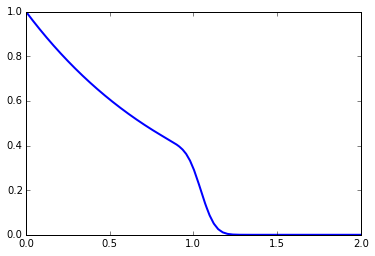

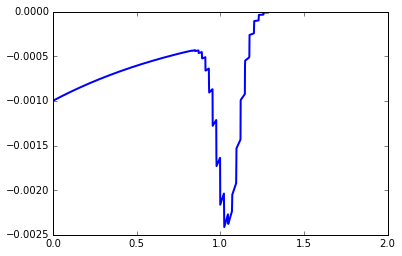

In [83]:
# print(min(slopes))

print(end1, end2)
plot(fade, optimize, lw=2.0)

figure()
# print(len(fade))
# print(len(slopes))
plot(arange(0, 1.999, 10**(-3)), slopes, lw=2.0)

In [106]:
def adaptive_endpoints(fx, fade):
    slopes = [fx[idx]-fx[idx-1] for idx in range(1, len(fx))]
    mid = fade[slopes.index(min(slopes))]
#     print(mid)
#     end1, end2 = mid - 5000*10**(-10), mid + 5000*10**(-10)
    end1, end2 = mid - 5000*10**(-6), mid + 5000*10**(-6)
    endpts = [end1, end2, 2]
    return endpts

In [116]:
# Adaptive
def p_single(codetable, op_SNR, endpoint, dfade, tabledSNR):
    fadexp = sp.stats.expon()
    fade = arange(0, endpoint, 10**(-3))
    psingle = []
    snrlookup = codetable(op_SNR+log10(fade))
    fadepr = fadexp.pdf(fade)
    optimize = snrlookup * fadepr
    endpts = adaptive_endpoints(optimize, fade)
#     dfade = [10**(-2), 10**(-5), 10**(-2)]
    fade = arange(0, endpts[0], dfade[0])
#     psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
    return sum(psingle)

In [90]:
def p_combo(codetable, a, op_SNR, endpoint, dfade, tabledSNR):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    pcombo = []
    fade = arange(0, endpoint, 10**(-3))
    snrlookup = codetable(op_SNR+log10(fade))
    fadepr = fadexp.pdf(fade)
    optimize = snrlookup * fadepr
    endpts = adaptive_endpoints(optimize, fade)
    fade = arange(0, endpts[0], dfade[0])
    pcombo.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        pcombo.append(dfade[idx]*np.dot(snrlookup, fadepr))
#         pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[idx] for f in fade]))
    return sum(pcombo)

In [104]:
# N = num_nodes
def p_protocol(codetable, N, op_SNR, endpoint, dfade, tabledSNR):
    psingle = p_single(codetable, op_SNR, endpoint, dfade, tabledSNR)
#     print('psingle', psingle,| 'pcombo, ')
    return sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * 
                (1-(1-p_combo(codetable, a, op_SNR, endpoint, dfade, tabledSNR))**(N-a)) for a in range(N)])

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


CPU times: user 2min 28s, sys: 1.94 s, total: 2min 30s
Wall time: 1min 27s


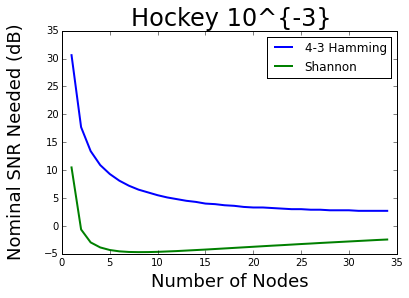

In [127]:
%%time
# Hockey Stick Plot
nominal_needed = []
shannon = []
dSNR = 0.01
dSNR, dfade, end = 0.01, [10**(-4), 10**(-4)], [1, 2]
threshold = 10**(-3)
for N in range(1, 35):
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)
    
    rate = N*160/10000
    SNR = -10 # dB scale
    pshannon = 1.0
    while pshannon > threshold:
        plink = 1 - exp(-(2**rate -1)/(10**(SNR/10)))
        pshannon = sum([nCr(N, a) * (1-plink)**a * plink**(N-a) * 
                         (1-(1-shannon_combo(N, a, rate, plink, SNR))**(N-a)) for a in range(N)])
        SNR += 0.01
#         print(SNR, pprotocol)
    shannon.append(SNR-0.01)


plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
plot(range(1, 35), array(shannon), lw=2.0, label='Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-3}', fontsize=24)
# savefig('hockey_test_3.pdf', bbox='tight')

In [114]:
print(10*array(nominal_needed))

[ 30.6  17.7  13.4  10.9   9.3   8.1   7.2   6.5   6.    5.5   5.1   4.8
   4.5   4.3   4.    3.9   3.7   3.6   3.4   3.3   3.3   3.2   3.1   3.
   3.    2.9   2.9   2.8   2.8   2.8   2.7   2.7   2.7   2.7]


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


CPU times: user 10.3 s, sys: 115 ms, total: 10.4 s
Wall time: 10.7 s


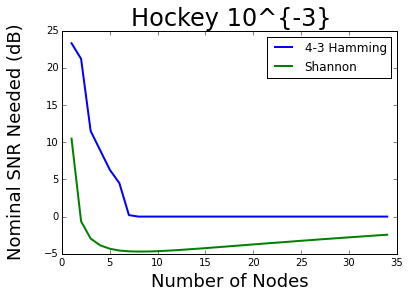

In [107]:
%%time
# Hockey Stick Plot
nominal_needed = []
shannon = []
dSNR = 0.01
dfade = [10**(-2), 10**(-5), 10**(-2)]
end = 2
# dSNR, dfade, end = 0.01, [10**(-4), 10**(-2)], [1, 2]
threshold = 10**(-3)
for N in range(1, 35):
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)
    
    rate = N*160/10000
    SNR = -10 # dB scale
    pshannon = 1.0
    while pshannon > threshold:
        plink = 1 - exp(-(2**rate -1)/(10**(SNR/10)))
        pshannon = sum([nCr(N, a) * (1-plink)**a * plink**(N-a) * 
                         (1-(1-shannon_combo(N, a, rate, plink, SNR))**(N-a)) for a in range(N)])
        SNR += 0.01
#         print(SNR, pprotocol)
    shannon.append(SNR-0.01)


plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
plot(range(1, 35), array(shannon), lw=2.0, label='Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-3}', fontsize=24)
# savefig('hockey_test_3.pdf', bbox='tight')

In [122]:
nominal_needed = []
shannon = []
dSNR = 0.01
dSNR, dfade, end = 0.01, [10**(-4), 10**(-4)], [2]
threshold = 10**(-3)
for N in range(1, 2):
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        print('op_SNR', SNR)
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
        print("=======")
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)
    

('op_SNR', 0)
('psingle', [0.6575064919935113])
('op_SNR', 0.01)
('psingle', [0.64906802598250124])
('op_SNR', 0.02)
('psingle', [0.64061280131627119])
('op_SNR', 0.03)
('psingle', [0.63215865823169226])
('op_SNR', 0.04)
('psingle', [0.6237046661509873])
('op_SNR', 0.05)
('psingle', [0.6152492724943146])
('op_SNR', 0.060000000000000005)
('psingle', [0.60680410236163917])
('op_SNR', 0.07)
('psingle', [0.59837423208186902])
('op_SNR', 0.08)
('psingle', [0.58995749839078826])
('op_SNR', 0.09)
('psingle', [0.58156572148163033])
('op_SNR', 0.09999999999999999)
('psingle', [0.57319630445547309])
('op_SNR', 0.10999999999999999)
('psingle', [0.56485359675487934])
('op_SNR', 0.11999999999999998)
('psingle', [0.55654186332658573])
('op_SNR', 0.12999999999999998)
('psingle', [0.548273122395323])
('op_SNR', 0.13999999999999999)
('psingle', [0.54003589038302591])
('op_SNR', 0.15)
('psingle', [0.5318418667307967])
('op_SNR', 0.16)
('psingle', [0.52369493658704924])
('op_SNR', 0.17)
('psingle', [0.51

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
